In [1]:
# this file collects all results for 8k, under 4 read out modes, up to cls=7 or 10.

In [2]:
from os.path import join, dirname, exists
from os import makedirs
from itertools import chain
from thesis_v2 import dir_dict

In [3]:
import pandas as pd

In [4]:
def load_data():
    ret = pd.concat(
        [
            pd.read_pickle(
                join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20201118', 'main_result_separatebn.pkl')
            ),
            pd.read_pickle(
                join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20201114', 'main_result_separatebn.pkl')
            ),
        ], axis=0
    ).sort_index()
    assert ret.index.is_unique
    return ret.dropna()

In [5]:
def load_main_results():
    # take main results and compare
    ret = pd.read_pickle(join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20200725+20200801+20200801_2', 'main_result.pkl'))
    ret = ret[ret.index.get_level_values('rcnn_bl_cls') <= 7]
    assert ret.index.is_unique
    return ret.dropna()

In [6]:
df_main_result_ref = load_main_results()
df_main_result = load_data()



In [7]:
aaaa = df_main_result_ref.join(df_main_result.dropna(), how='inner', lsuffix='_ref', rsuffix='_new').sort_index()

In [8]:
aaaa

cc2_normed_avg_ref  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                       
relu     False                mse       0          2         8           2           cm-avg       1280                  0.390532   
                                                                                                  2560                  0.536576   
                                                                                                  5120                  0.580945   
                                                                                     cm-last      1280                  0.376278   
                                                                                                  2560                  0.579874   
...                                                                                                                          ...   
softplus True                 poisson   1          3         32          3           inst-avg     2560                  0.639769   
                                                                                                  5120                  0.673392   
                                                                                     inst-last    1280                  0.568706   
                                                                                                  2560                  0.626743   
                                                                                                  5120                  0.663524   

                                                                                                              cc2_raw_avg_ref  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                    
relu     False                mse       0          2         8           2           cm-avg       1280               0.187182   
                                                                                                  2560               0.250899   
                                                                                                  5120               0.269328   
                                                                                     cm-last      1280               0.178842   
                                                                                                  2560               0.269225   
...                                                                                                                       ...   
softplus True                 poisson   1          3         32          3           inst-avg     2560               0.294604   
                                                                                                  5120               0.309649   
                                                                                     inst-last    1280               0.263007   
                                                                                                  2560               0.289067   
                                                                                                  5120               0.304765   

                                                                                                              cc_raw_avg_ref  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                   
relu     False                mse       0          2         8           2           cm-avg       1280              0.398958   
                                                                                                  2560              0.477141   
                                                                                                  5120              0.498833   
                                                                           

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from thesis_v2.plots.basic import scatter
from thesis_v2.plots.util import savefig

In [10]:
from scipy.stats import pearsonr, spearmanr

1280
2560
5120


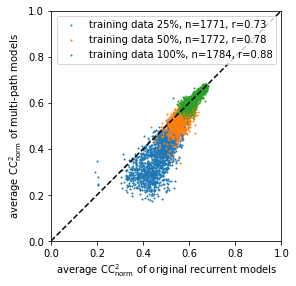

In [12]:
def plot_scatter():
    # check performance diff between two readout types
    plt.close('all')
    fig, ax = plt.subplots(squeeze=True, figsize=(4,4))
    training_data_mapping = {
        1280: '25%',
        2560: '50%',
        None: '100%',
        5120: '100%',
    }
    for train_keep in aaaa.index.get_level_values('train_keep').unique():
        b = aaaa.xs(train_keep, level='train_keep')
        n = b.shape[0]
        r = pearsonr(b['cc2_normed_avg_ref'].values, b['cc2_normed_avg_new'].values)[0]
        ax.scatter(b['cc2_normed_avg_ref'].values, b['cc2_normed_avg_new'].values, s=1,
                   label='training data {}, n={}, r={:.2f}'.format(
                       training_data_mapping[train_keep], n, r
                   )
                  )
        
        # compute pearson
        print(train_keep)
        
        
    ax.set_xlabel('''average ${\\mathrm{CC}}_{\\mathrm{norm}}^2$ of original recurrent models''')
    ax.set_ylabel('''average ${\\mathrm{CC}}_{\\mathrm{norm}}^2$ of multi-path models''')
    ax.plot([0,1],[0,1],linestyle='--',color='k')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.legend()
    
    pltdir = join(dir_dict['plots'], 'yuanyuan_8k_a_3day_refactored', '20201114+20201118')
    makedirs(pltdir, exist_ok=True)
    fig.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
    savefig(fig, join(pltdir, 'multi_vs_r.pdf'))
    
    plt.show()
    
    

    
plot_scatter()

# more channels lead to higher correlation.
# which is kind of expected, because deep + thin leads to bad convergence properties.
# why -last performed worse than -avg: probably because there is more supervision in -avg during training.
# -avg training is used in K's paper
